In [17]:
### Dependencies ----------------------------------------------------------------
import pandas as pd # used for working with data sets


###COMBINE ALL .CSVS INTO ONE
file_path = r"..\data\combined.csv"


data = pd.read_csv(file_path)

# # Slovník číselníků
# num_dict = {
#     'Prague-outskirts': 1,
#     'Prague-center': 2,
#     'Prague': 3
# }

# # Nový sloupec 'neighb_num' v DataFrame
# data['neighb_num'] = data['neighbourhood_cleansed'].map(num_dict)

# data.head()


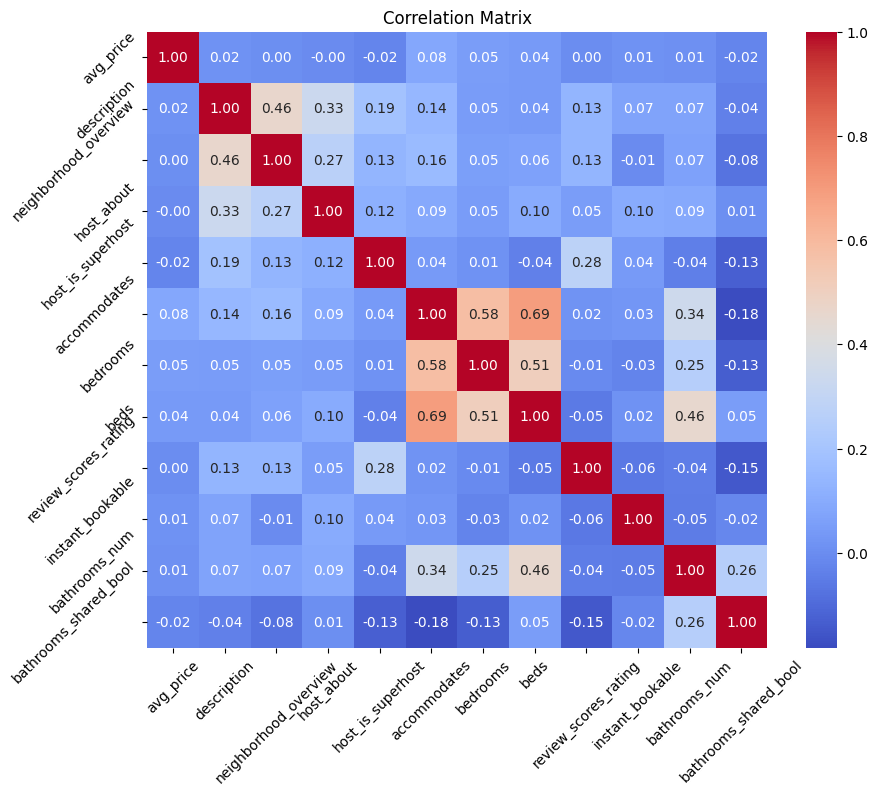

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_columns = ['avg_price','description', 'neighborhood_overview', 'host_about', 'host_is_superhost',
                   'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'instant_bookable',
                   'bathrooms_num', 'bathrooms_shared_bool']  

selected_data = data[selected_columns]

correlation_matrix = selected_data.corr(method='pearson')

# Nastavení velikosti obrázku
plt.figure(figsize=(10, 8))

# Vytvoření heatmapy
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Nastavení popisků os
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Zobrazení grafu
plt.show()


In [25]:
# vytvoření dummy proměnných pro regrese

# One-Hot Encoding pro weathercode
neighbourhood_dummies = pd.get_dummies(data['neighbourhood_cleansed'], prefix='neighb-')
room_dummies = pd.get_dummies(data['room_type'], prefix='room-')


# Přidání zakódovaných sloupců zpět do dat
data = pd.concat([data, neighbourhood_dummies], axis=1)
data = pd.concat([data, room_dummies], axis=1)

data.head()

,description,neighborhood_overview,host_since,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,...,room-_Hotel room,room-_Private room,room-_Shared room,neighb-_Prague,neighb-_Prague-center,neighb-_Prague-outskirts,room-_Entire home/apt,room-_Hotel room,room-_Private room,room-_Shared room
0,4,1,1,1,1,1,1,Prague,Private room,2,...,False,True,False,True,False,False,False,False,True,False
1,4,1,1,0,1,1,1,Prague-center,Entire home/apt,5,...,False,False,False,False,True,False,True,False,False,False
2,3,1,1,1,0,1,1,Prague-center,Entire home/apt,4,...,False,False,False,False,True,False,True,False,False,False
3,2,0,1,0,0,0,1,Prague-outskirts,Entire home/apt,1,...,False,False,False,False,False,True,True,False,False,False
4,3,1,1,1,1,1,1,Prague-center,Entire home/apt,4,...,False,False,False,False,True,False,True,False,False,False


In [30]:
## dělba na datasety, ale nějak se to jebe, je to potřeba polatid, aby to fakt bylo správně podle toho data, chyba je nejspíš v tom postupu toho train test splitu...

#from sklearn.model_selection import train_test_split

# # Převedení sloupce 'date' na datový typ datetime
# data['date'] = pd.to_datetime(data['date'])

# Seřazení dat podle data
data_sorted = data.sort_values(by='date', ascending=True)

print(data_sorted['date'])

# # Rozdělení dat na trénovací, validační a testovací množiny
# train_data, test_valid_data = train_test_split(data_sorted, test_size=0.4, shuffle=False)
# valid_data, test_data = train_test_split(test_valid_data, test_size=0.5, shuffle=False)

# # Uložení jednotlivých množin do DataFrame
# train_df = pd.DataFrame(train_data)
# valid_df = pd.DataFrame(valid_data)
# test_df = pd.DataFrame(test_data)

total_rows = len(data_sorted)
train_idx = int(total_rows * 0.6)
valid_idx = int(total_rows * 0.8)

X_train = data_sorted.iloc[:train_idx].drop(['avg_price','neighbourhood_cleansed','room_type','date','review_scores_rating'], axis=1)
y_train = data_sorted.iloc[:train_idx]['avg_price']

X_valid = data_sorted.iloc[train_idx:valid_idx].drop(['avg_price','neighbourhood_cleansed','room_type','date','review_scores_rating'], axis=1)
y_valid = data_sorted.iloc[train_idx:valid_idx]['avg_price']

X_test = data_sorted.iloc[valid_idx:].drop(['avg_price','neighbourhood_cleansed','room_type','date','review_scores_rating'], axis=1)
y_test = data_sorted.iloc[valid_idx:]['avg_price']




0         2023-06-01
5626      2023-06-01
5625      2023-06-01
5624      2023-06-01
5623      2023-06-01
             ...    
136230    2024-09-01
136231    2024-09-01
136232    2024-09-01
136226    2024-09-01
142189    2024-09-01
Name: date, Length: 142190, dtype: object


In [20]:
num_rows_train = len(X_train)
num_rows_valid = len(X_valid)
num_rows_test = len(X_test)

print(f"Number of rows in training data: {num_rows_train}")
print(f"Number of rows in validation data: {num_rows_valid}")
print(f"Number of rows in testing data: {num_rows_test}")

Number of rows in training data: 85314
Number of rows in validation data: 28438
Number of rows in testing data: 28438


In [21]:
# Kontrola výsledků
print("Trénovací data:")
print(X_train['date'].head())
print("\nValidační data:")
print(X_valid['date'].head())
print("\nTestovací data:")
print(X_test['date'].head())


Trénovací data:
0       2023-06-01
5626    2023-06-01
5625    2023-06-01
5624    2023-06-01
5623    2023-06-01
Name: date, dtype: object

Validační data:
80052    2024-03-01
80054    2024-03-01
80055    2024-03-01
80056    2024-03-01
80057    2024-03-01
Name: date, dtype: object

Testovací data:
110624    2024-06-01
110623    2024-06-01
110622    2024-06-01
110621    2024-06-01
110620    2024-06-01
Name: date, dtype: object


In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Vytvoření a trénování lineární regrese
model = LinearRegression()
model.fit(X_train, y_train)

# Predikce na testovací množině
y_pred = model.predict(X_valid)

# Výpočet Mean Squared Error
mse = mean_squared_error(y_valid, y_pred)
coefficients_train_rel = model.coef_
intercept_train_rel = model.intercept_


# Výpis výsledků
print("Intercept:", intercept_train_rel )
print("Coefficients:", coefficients_train_rel)
print("Mean Squared Error:", mse)  

rmse = mse**(1/2)
print("Root Mean Squared Error:",rmse)


Intercept: -5086438.301381821
Coefficients: [ 1.09367428e+02 -3.96845160e+02 -8.24344801e+01 -2.25638482e+02
 -7.87184476e+02  8.77827047e+02 -7.76153893e+03  7.99834826e+02
  1.69197529e+02 -1.50615833e+02 -4.17571900e+00  5.09823055e+02
 -8.24344801e+01 -2.18702282e+02 -4.76879999e+02  2.51697037e+03
  2.17277602e+02  3.97570380e+01  7.52325620e+02 -7.92082658e+02
  7.11161536e+01 -5.82686479e+01  4.10908907e+02 -4.23756412e+02
  3.97570380e+01  7.52325620e+02 -7.92082658e+02  7.11161536e+01
 -5.82686479e+01  4.10908907e+02 -4.23756412e+02]
Mean Squared Error: 659737850.7110155
Root Mean Squared Error: 25685.362576981766


Intercept je číslo, kde je X = 0 -> kdy ta pomyslná přímka té regrese protíná osu Y. Intercept se přičítá vždycky k tý hodnotě a podle toho, jaký hodnoty dosahuje proměnná každého z těch koeficientů, tak se to tím buď násobí nebo ne. Ty koeficienty jsou za sebou seřazené tak, jak do té regrese vstupovaly ty jednotlivé parametry -> z leva do prava v tabulce všechno kromě dropnutých sloupečků. Odchylka je šílená.

In [36]:
from sklearn.linear_model import Lasso

# Vytvoření modelu Lasso regrese
alpha = 1  # Parametr regularizace, můžete experimentovat s různými hodnotami
lasso = Lasso(alpha=alpha)

# Naučení modelu na trénovacích datech
lasso.fit(X_train, y_train)

# Predikce na testovacích datech
Y_pred = lasso.predict(X_valid)

# Interpretace koeficientů
intercept_bal_rel_lasso = lasso.intercept_
coefficients_bal_rel_lasso = lasso.coef_
mse = mean_squared_error(y_valid, Y_pred)
rmse = mse**(1/2)


# Výpis výsledků
print("Intercept:", intercept_bal_rel_lasso)
print("Coefficients:", coefficients_bal_rel_lasso)
print("Mean Squared Error:", mse)  
print("Root Mean Squared Error:", rmse)


Intercept: -5039500.627058397
Coefficients: [ 1.07994645e+02 -3.91133446e+02 -1.49640042e-03 -2.23310198e+02
 -7.82243814e+02  8.11364530e+02 -7.72783945e+03  8.01845863e+02
  1.69504660e+02 -1.53041119e+02 -4.18044102e+00  5.03619619e+02
 -1.11365478e+02 -2.21849240e+02 -4.66208061e+02  2.49387940e+03
  2.14725353e+02 -0.00000000e+00  1.35588976e+03 -1.56707923e+03
  5.38090309e-04 -1.92513582e+02  6.74018045e+02 -8.24023315e+02
  0.00000000e+00  6.77564505e+01 -6.96885947e+01  3.54256792e+00
 -3.09254167e-05  1.32006343e+00 -7.17458922e+01]
Mean Squared Error: 659744545.9636743
Root Mean Squared Error: 25685.4929087155
